# Efficient GAN-Based Anomaly Detection
https://arxiv.org/pdf/1802.06222

In [1]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
DRIVE_ROOT = Path('/content/drive/MyDrive')

DATA_ROOT= Path('./data/')
MODEL_ROOT = DRIVE_ROOT / 'weights'

!mkdir -p {DATA_ROOT}
!mkdir -p {MODEL_ROOT}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install -q matplotlib
%pip install -q torchviz torchinfo
%pip install -q tqdm

In [3]:
from IPython.display import display

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary
from torchvision import datasets, models, ops, transforms

%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (3, 3)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

def get_device():
    '''Get device (CPU or GPU).'''
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Network models and the loss
Just like before, Binary Cross Entropy is used as the loss function. In this case, that is  $-log D(\text{image}, \text{noise})$.

So, for the real image input 'x':
$$ loss_{real} = -log D(x, E(x)) $$

and for the noize input 'z':
$$ loss_{fake} = -log(D(G(z), z)) $$

Here, $G$, $D$, and $E$ denote the generator, discriminator, and encoder networks, respectively.

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=20):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.last = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        z = self.layer1(z)
        z = self.layer2(z)

        z = z.view(z.shape[0], 128, 7, 7)
        z = self.layer3(z)
        z = self.last(z)
        return z

In [5]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()

        self.x_layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.x_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.z_layer1 = nn.Linear(z_dim, 512)

        self.last1 = nn.Sequential(
            nn.Linear(3648, 1024),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.last2 = nn.Linear(1024, 1)

    def forward(self, x, z):
        x = self.x_layer1(x)
        x = self.x_layer2(x)
        x = torch.flatten(x, start_dim=1)

        z = z.view(z.shape[0], -1)
        z = self.z_layer1(z)

        out = torch.cat([x, z], dim=1)
        out = self.last1(out)

        feature = torch.flatten(out, start_dim=1)

        out = self.last2(out)
        return out, feature

In [6]:
class Encoder(nn.Module):
    def __init__(self, z_dim=20):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.last = nn.Linear(128 * 7 * 7, z_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = torch.flatten(x, start_dim=1)
        x = self.last(x)
        return x

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def build_GAN(z_dim=20):
    G = Generator(z_dim=z_dim).apply(weights_init)
    D = Discriminator(z_dim=z_dim).apply(weights_init)
    E = Encoder(z_dim=z_dim).apply(weights_init)
    return G, D, E

## Training a DCGAN model with the target dataset

In [8]:
class ImageTransform():
    def __init__(self, mean, std, image_size):
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, image):
        return self.transform(image)

class TinyMnistDataset(Dataset):
    def __init__(self, root, train, keys, transform=None, download=True, num_images=200):
        self.dataset = datasets.MNIST(root=root, train=train, download=download)
        self.transform = transform

        self.indices = []
        for key in keys:
            key_indices = np.where(np.array(self.dataset.targets) == key)[0]
            self.indices += list(key_indices[:num_images])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, _ = self.dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image

In [9]:
def train(generator, discriminator, encoder, criterion, g_optimizer, d_optimizer, e_optimizer, data_loader, device):
    generator.train()
    discriminator.train()
    encoder.train()

    total_g_loss = 0
    total_d_loss = 0
    total_e_loss = 0
    for images in data_loader:
        images = images.to(device)
        batch_size = images.shape[0]

        # -----------------------
        # 1. Train Discriminator
        # -----------------------
        # Generate z_inputs from real images and realness score from the z.
        z_out_real = encoder(images)
        d_out_real, _ = discriminator(images, z_out_real)

        # Generate z_inputs from fake images and realness score from the z.
        input_z = torch.randn(batch_size, z_dim).to(device)
        fake_images = G(input_z)
        d_out_fake, _ = D(fake_images, input_z)

        # Prepare labels.
        label_real = torch.full((batch_size,), 1, dtype=torch.float).to(device)
        label_fake = torch.full((batch_size,), 0, dtype=torch.float).to(device)

        # Calculate the loss.
        d_loss_real = criterion(d_out_real.view(-1), label_real)
        d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
        d_loss = d_loss_real + d_loss_fake

        # Backpropagate the loss and update the discriminator.
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # -----------------------
        # 2. Train Generator
        # -----------------------
        # Generate fake images from random noise.
        input_z = torch.randn(batch_size, z_dim).to(device)
        fake_images = G(input_z)
        d_out_fake, _ = D(fake_images, input_z)

        # Calculate the loss (This provides high loss when the discriminator see through fake images.)
        g_loss = criterion(d_out_fake.view(-1), label_real)

        # Backpropagate the loss and update the generator.
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # -----------------------
        # 3. Train Encoder
        # -----------------------
        # Generate fake images from random noise.
        z_out_real = encoder(images)
        d_out_fake, _ = D(images, z_out_real)

        # Calculate the loss.
        e_loss = criterion(d_out_fake.view(-1), label_fake)

        # Backpropagate the loss and update the discriminator.
        e_optimizer.zero_grad()
        e_loss.backward()
        e_optimizer.step()

        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()
        total_e_loss += e_loss.item()

    return total_g_loss / len(data_loader), total_d_loss / len(data_loader), total_e_loss / len(data_loader)


def train_GAN(G, D, E, criterion, g_optimizer, d_optimizer, e_optimizer, data_loader, num_epochs):
    device = get_device()
    torch.backends.cudnn.benchmark = True

    G.to(device)
    D.to(device)
    E.to(device)
    for epoch in range(num_epochs):
        g_loss, d_loss, e_loss = train(G, D, E, criterion, g_optimizer, d_optimizer, e_optimizer, data_loader, device)

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}, e_loss: {e_loss:.4f}')

In [10]:
MEAN = (0.5,)
STD = (0.5,)
image_size = 28
batch_size = 64

train_dataset = TinyMnistDataset(
    root=DATA_ROOT, train=True, keys=[7, 8], transform=ImageTransform(MEAN, STD, image_size))

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

In [11]:
num_epochs = 1500
z_dim = 20
ge_lr = 0.0001
d_lr = 0.0001/4
beta1, beta2 = 0.5, 0.999

G, D, E = build_GAN(z_dim=z_dim)

criterion = nn.BCEWithLogitsLoss(reduction='mean')
g_optimizer = torch.optim.Adam(G.parameters(), ge_lr, [beta1, beta2])
d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])
e_optimizer = torch.optim.Adam(E.parameters(), ge_lr, [beta1, beta2])

train_GAN(G, D, E, criterion, g_optimizer, d_optimizer, e_optimizer, train_dataloader, num_epochs)

Epoch [100/1500], g_loss: 1.0368, d_loss: 0.9905, e_loss: 1.1314
Epoch [200/1500], g_loss: 1.0618, d_loss: 0.8924, e_loss: 1.2206
Epoch [300/1500], g_loss: 1.4064, d_loss: 0.7613, e_loss: 1.4467
Epoch [400/1500], g_loss: 1.6682, d_loss: 0.5608, e_loss: 1.7682
Epoch [500/1500], g_loss: 1.9699, d_loss: 0.5641, e_loss: 1.9519
Epoch [600/1500], g_loss: 2.4193, d_loss: 0.3528, e_loss: 2.1524
Epoch [700/1500], g_loss: 2.6671, d_loss: 0.2539, e_loss: 2.5497
Epoch [800/1500], g_loss: 3.0547, d_loss: 0.1813, e_loss: 2.9392
Epoch [900/1500], g_loss: 3.1590, d_loss: 0.1745, e_loss: 3.0489
Epoch [1000/1500], g_loss: 3.7279, d_loss: 0.1278, e_loss: 3.2551
Epoch [1100/1500], g_loss: 3.6857, d_loss: 0.1379, e_loss: 3.3052
Epoch [1200/1500], g_loss: 4.3456, d_loss: 0.0841, e_loss: 3.7921
Epoch [1300/1500], g_loss: 4.5604, d_loss: 0.0772, e_loss: 4.1180
Epoch [1400/1500], g_loss: 5.2929, d_loss: 0.0557, e_loss: 3.9398
Epoch [1500/1500], g_loss: 5.3078, d_loss: 0.0544, e_loss: 4.3945


## Anomaly Detection

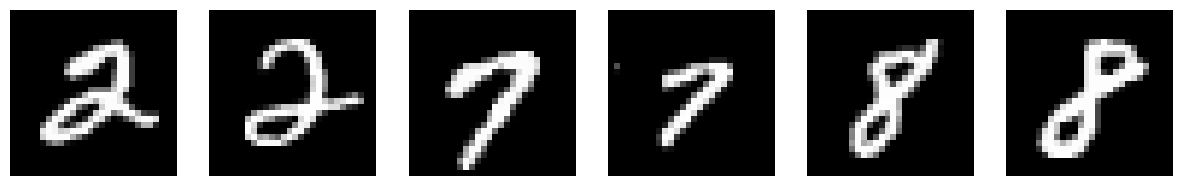

In [12]:
test_dataset = TinyMnistDataset(
    root=DATA_ROOT, train=True, keys=[2, 7, 8], num_images=2)
batch_size = len(test_dataset)

fig = plt.figure(figsize=(15, 6))
for i, image in enumerate(test_dataset):
    plt.subplot(1, batch_size, i + 1)
    plt.imshow(image, 'gray')
    plt.axis('off')

In [13]:
def calculate_anomaly_score(target_images, fake_images, z_out_real, D, lambda_weight=0.1):
    residual_loss = torch.abs(target_images - fake_images)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    _, t_feature = D(target_images, z_out_real)
    _, G_feature = D(fake_images, z_out_real)
    discrimination_loss = torch.abs(t_feature - G_feature)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    loss_each = (1-lambda_weight)*residual_loss + lambda_weight*discrimination_loss
    total_loss = torch.sum(loss_each)

    return total_loss, loss_each

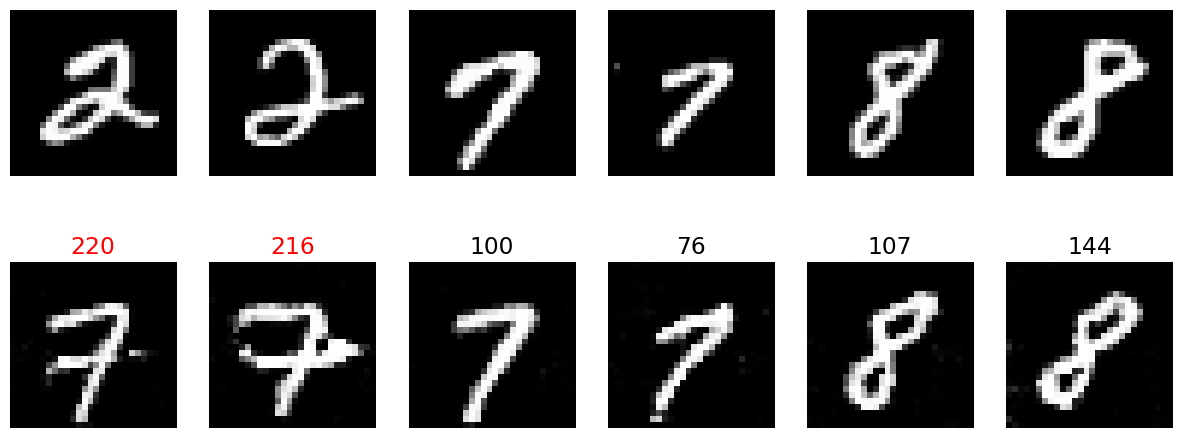

In [16]:
score_threshold = 150
device = get_device()

transform=ImageTransform(MEAN, STD, image_size)
targets = torch.stack([transform(image) for image in test_dataset])
targets = targets.to(device)

G.eval()
D.eval()
E.eval()
z_out_real = E(targets.to(device))
fake_images = G(z_out_real)

loss, loss_each = calculate_anomaly_score(targets, fake_images, z_out_real, D)
loss_each = loss_each.cpu().detach().numpy()

fig = plt.figure(figsize=(15, 6))
for i in range(batch_size):
    plt.subplot(2, batch_size, i+1)
    plt.imshow(targets[i][0].cpu().detach().numpy(), 'gray')
    plt.axis('off')

    plt.subplot(2, batch_size, batch_size+i+1)
    title_color = 'red' if loss_each[i] >= score_threshold else 'black'
    plt.title(f'{loss_each[i]:.0f}', color=title_color)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')
    plt.axis('off')